In [1]:

#import packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
df = pd.read_csv('mubawab_listings_eda.csv')

In [3]:

df.head()

,Type,Localisation,Price,Area,Rooms,Bedrooms,Bathrooms,Floor,Other_tags,Price_m2,Current_state,Age
0,Appartements,Anfa,1230000,86.0,3.0,2.0,2.0,1.0,"['Bon état', '10-20 ans']",14302.325581,Bon état,10-20 ans
1,Appartements,La Gironde,900000,86.0,3.0,2.0,1.0,5.0,"['Bon état', '10-20 ans']",10465.116279,Bon état,10-20 ans
2,Appartements,Bourgogne Ouest,2400000,180.0,5.0,3.0,3.0,3.0,"['Bon état', '10-20 ans']",13333.333333,Bon état,10-20 ans
3,Appartements,Les princesses,1550000,120.0,5.0,3.0,2.0,5.0,"['Bon état', '5-10 ans']",12916.666667,Bon état,5-10 ans
4,Appartements,Bourgogne Ouest,1450000,113.0,4.0,3.0,2.0,1.0,"['Bon état', '10-20 ans']",12831.858407,Bon état,10-20 ans


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           892 non-null    object 
 1   Localisation   892 non-null    object 
 2   Price          892 non-null    int64  
 3   Area           892 non-null    float64
 4   Rooms          892 non-null    float64
 5   Bedrooms       892 non-null    float64
 6   Bathrooms      892 non-null    float64
 7   Floor          892 non-null    float64
 8   Other_tags     892 non-null    object 
 9   Price_m2       892 non-null    float64
 10  Current_state  855 non-null    object 
 11  Age            653 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 83.8+ KB


In [5]:

#Select columns to keep for modeling
cols_to_keep = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age','Price']
df_model = df[cols_to_keep]


In [6]:
#Data preprocessing : Missing values
display(df_model.isna().sum())

Type               0
Localisation       0
Area               0
Rooms              0
Bedrooms           0
Bathrooms          0
Floor              0
Current_state     37
Age              239
Price              0
dtype: int64

In [7]:

#Split dataframe into Features and Target Variable

features = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age']
X = df_model[features]
y = df_model['Price'].values 

In [8]:
#Encode ordinal variables

X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-50 ans",6).replace("50-70 ans",7)



C:\Users\R.BENZARIA\AppData\Local\Temp\ipykernel_9988\2070120809.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
C:\Users\R.BENZARIA\AppData\Local\Temp\ipykernel_9988\2070120809.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-

In [9]:

#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [11]:


#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,test_size = 0.3,random_state = 123)

In [12]:

#Scale the features using robust_scaler
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test),columns = X_test.columns)


In [13]:

#define function to evaluate linear models
def evaluate_linear_model(X_train,y_train,X_test,y_test,reg,grid = False):
    
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    RMSE_error_train = np.sqrt(MSE(y_train,reg.predict(X_train)))
    RMSE_error = np.sqrt(MSE(y_test,y_pred))
    MAPE_train = np.median(MAPE(y_train,reg.predict(X_train),multioutput = 'raw_values'))
    MAPE_test = np.median(MAPE(y_test,y_pred, multioutput = 'raw_values'))
    
    if grid:
        print(f'Best estimator parameters : {reg.best_params_}')
        reg = reg.best_estimator_
        
    
    print(f'train RMSE : {RMSE_error_train:.2f}')
    print(f'test RMSE : {RMSE_error:.2f}')
    print(f'train MAPE : {MAPE_train:.4f}')
    print(f'test MAPE : {MAPE_test:.4f}')
    print(f'Training set score (R^2): {reg.score(X_train,y_train):.2f}')
    print(f'Test set score (R^2): {reg.score(X_test,y_test):.2f}')
    coef_matrix = pd.DataFrame(np.hstack([reg.intercept_,reg.coef_]).reshape(1,-1),columns = np.hstack(['Intercept',X_train.columns]))
    display(coef_matrix)
    
    error_matrix = np.array([y_test,(y_test-y_pred)/y_test])

    fig,axes = plt.subplots(2,2,figsize = (20,16))
    
    ax1 = plt.subplot2grid((2,2),(0,0),rowspan=2)
    ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1)
    ax3 = plt.subplot2grid((2,2),(1,1),colspan = 1)
    
    g = sns.barplot(y = coef_matrix.columns,x = coef_matrix.iloc[0,:] ,color = cust_pal[5],ax=ax1)
    ax1.tick_params('x',rotation = 45)
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    

    g = sns.regplot(x = y_test,y = reg.predict(X_test),color = cust_pal[5],ax=ax2)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    g = sns.histplot(x = error_matrix[1,:],bins = 50,kde = True, color = cust_pal[5],ax = ax3)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(x,'%')))
    #g = sns.jointplot(x = error_matrix[0,:], y= error_matrix[1,:],color = cust_pal[5], height = 8, ratio = 5)
    
    plt.tight_layout()
    plt.show()
    
cust_pal = sns.color_palette(sns.light_palette('#0d874b',10))

train RMSE : 1964717.13
test RMSE : 2193307.52
train MAPE : 0.2284
test MAPE : 0.2335
Training set score (R^2): 0.94
Test set score (R^2): 0.91


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Type_Appartements,Type_Villas,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Current_state_2,Current_state_3,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7
0,495811.762202,12570.609958,-29121.887745,-31091.793718,434475.675928,-36056.360923,-422519.550096,422519.550112,930293.313889,-422973.361249,...,265945.64806,-280430.681767,269611.605567,370909.566627,376133.285481,-163773.264425,-130504.784515,-736337.705553,13961.296815,0.0


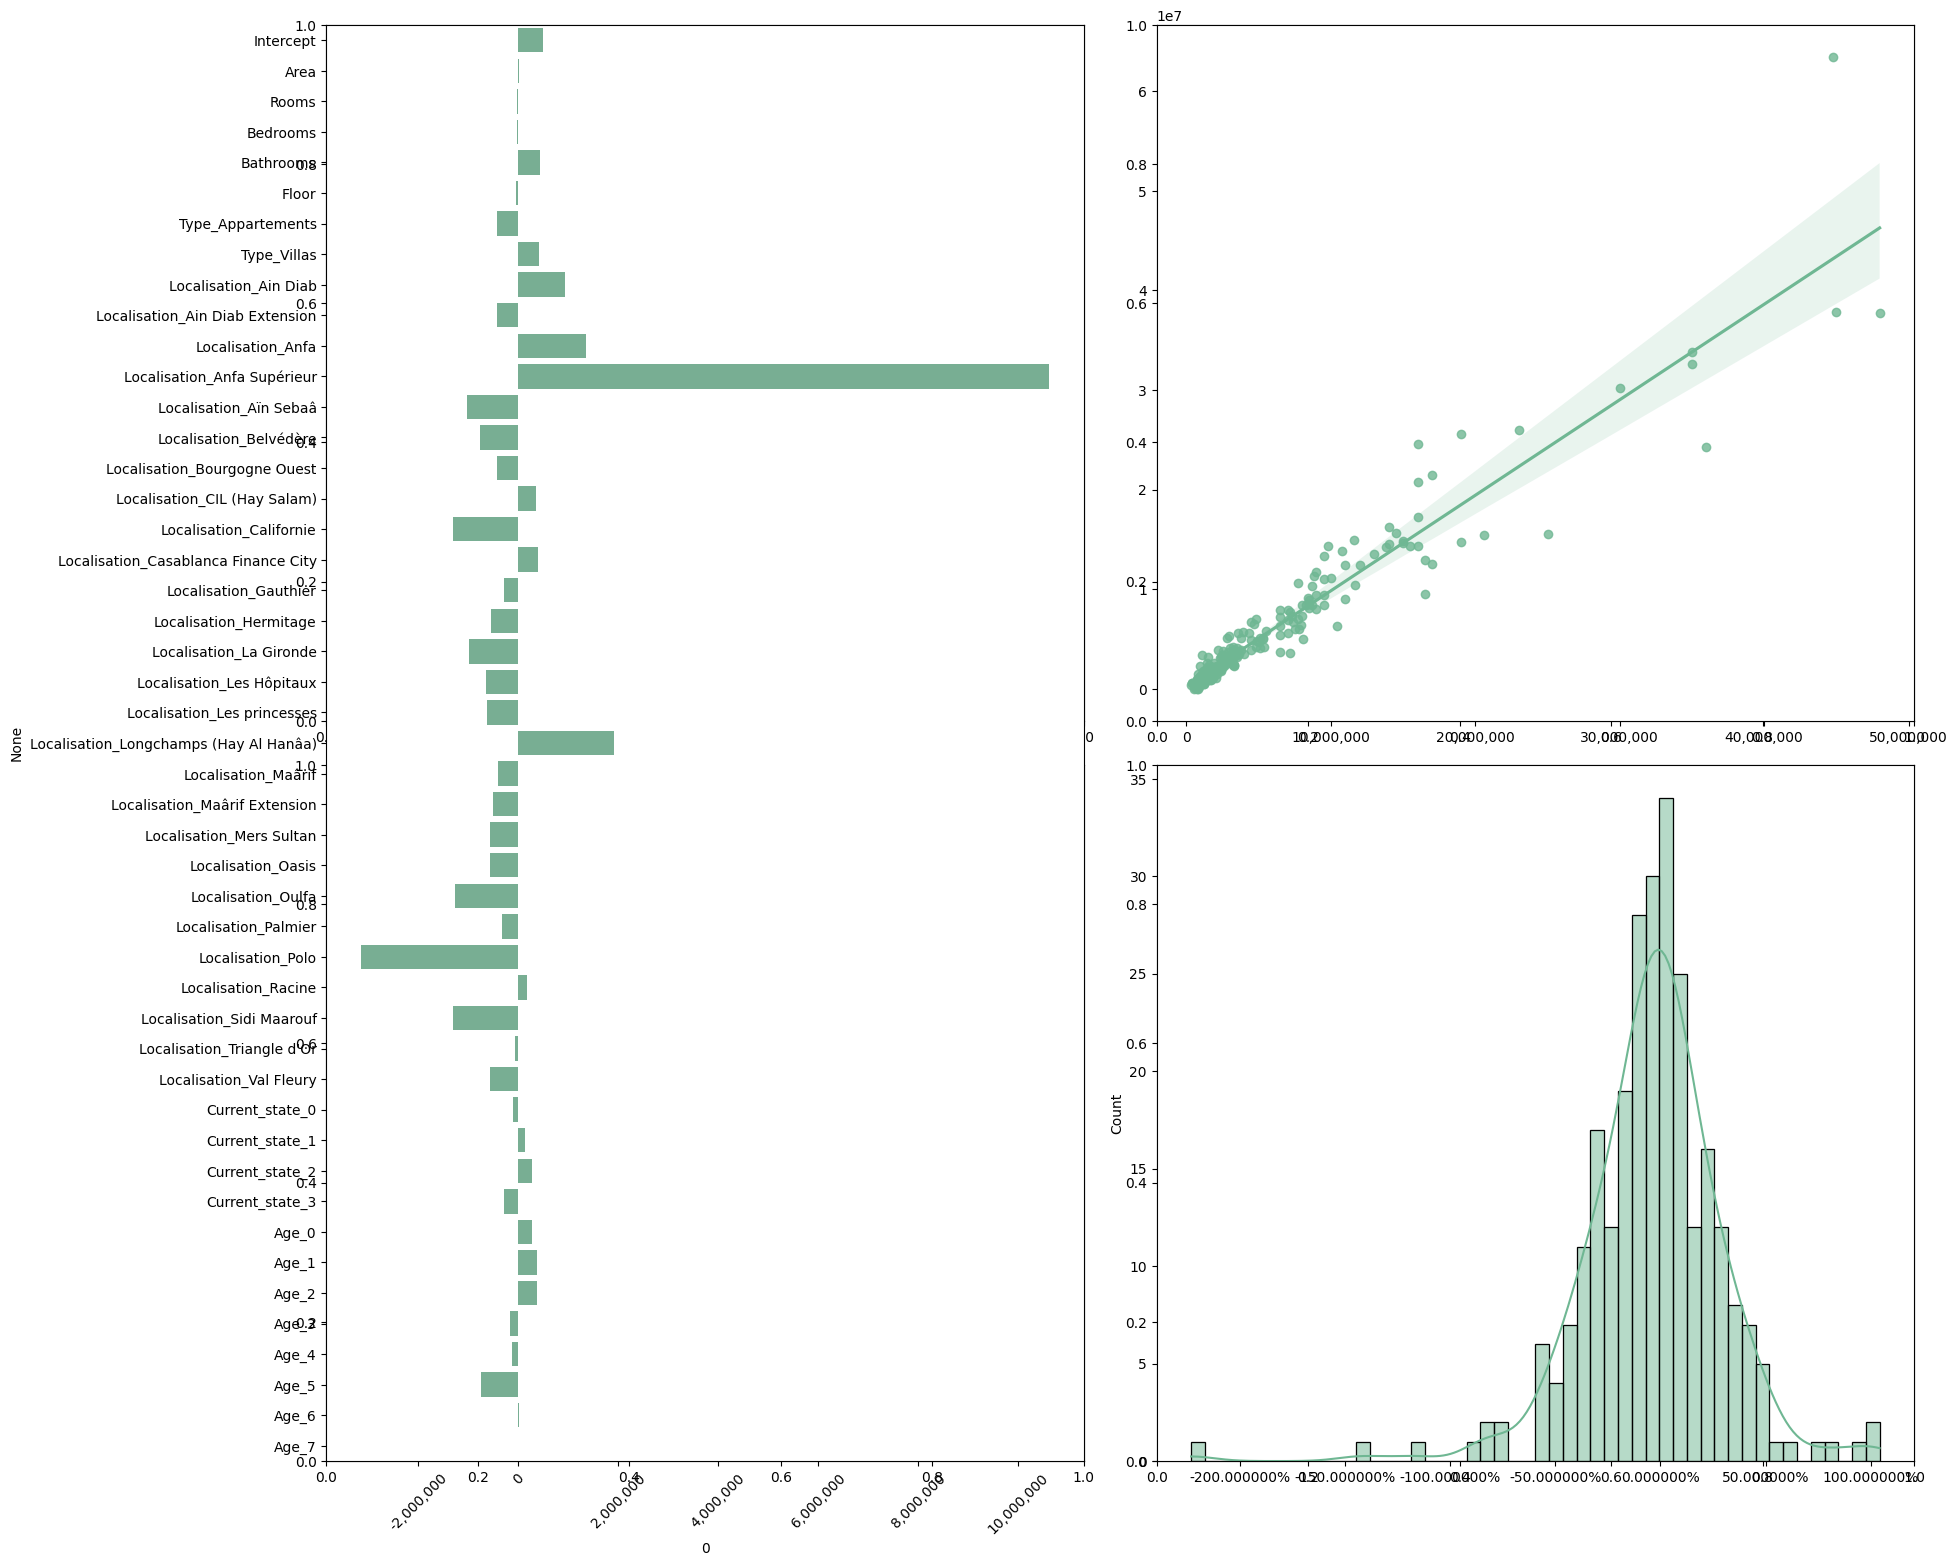

In [14]:

#Evaluate multivariate ols linear regression

linear_regression = LinearRegression()
evaluate_linear_model(X_train,y_train,X_test,y_test,linear_regression)

Best estimator parameters : {'alpha': 0.1}
train RMSE : 1964773.23
test RMSE : 2195531.17
train MAPE : 0.2279
test MAPE : 0.2335
Training set score (R^2): 0.94
Test set score (R^2): 0.91


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Type_Appartements,Type_Villas,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Current_state_2,Current_state_3,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7
0,496769.838337,12582.970067,-28722.05293,-32464.112615,433665.441762,-35930.180364,-427402.674427,427402.674427,921601.603553,-427313.645462,...,262353.35362,-276949.486391,271978.50553,368282.131332,377585.284928,-161613.771456,-127884.284518,-733540.922006,5193.056189,0.0


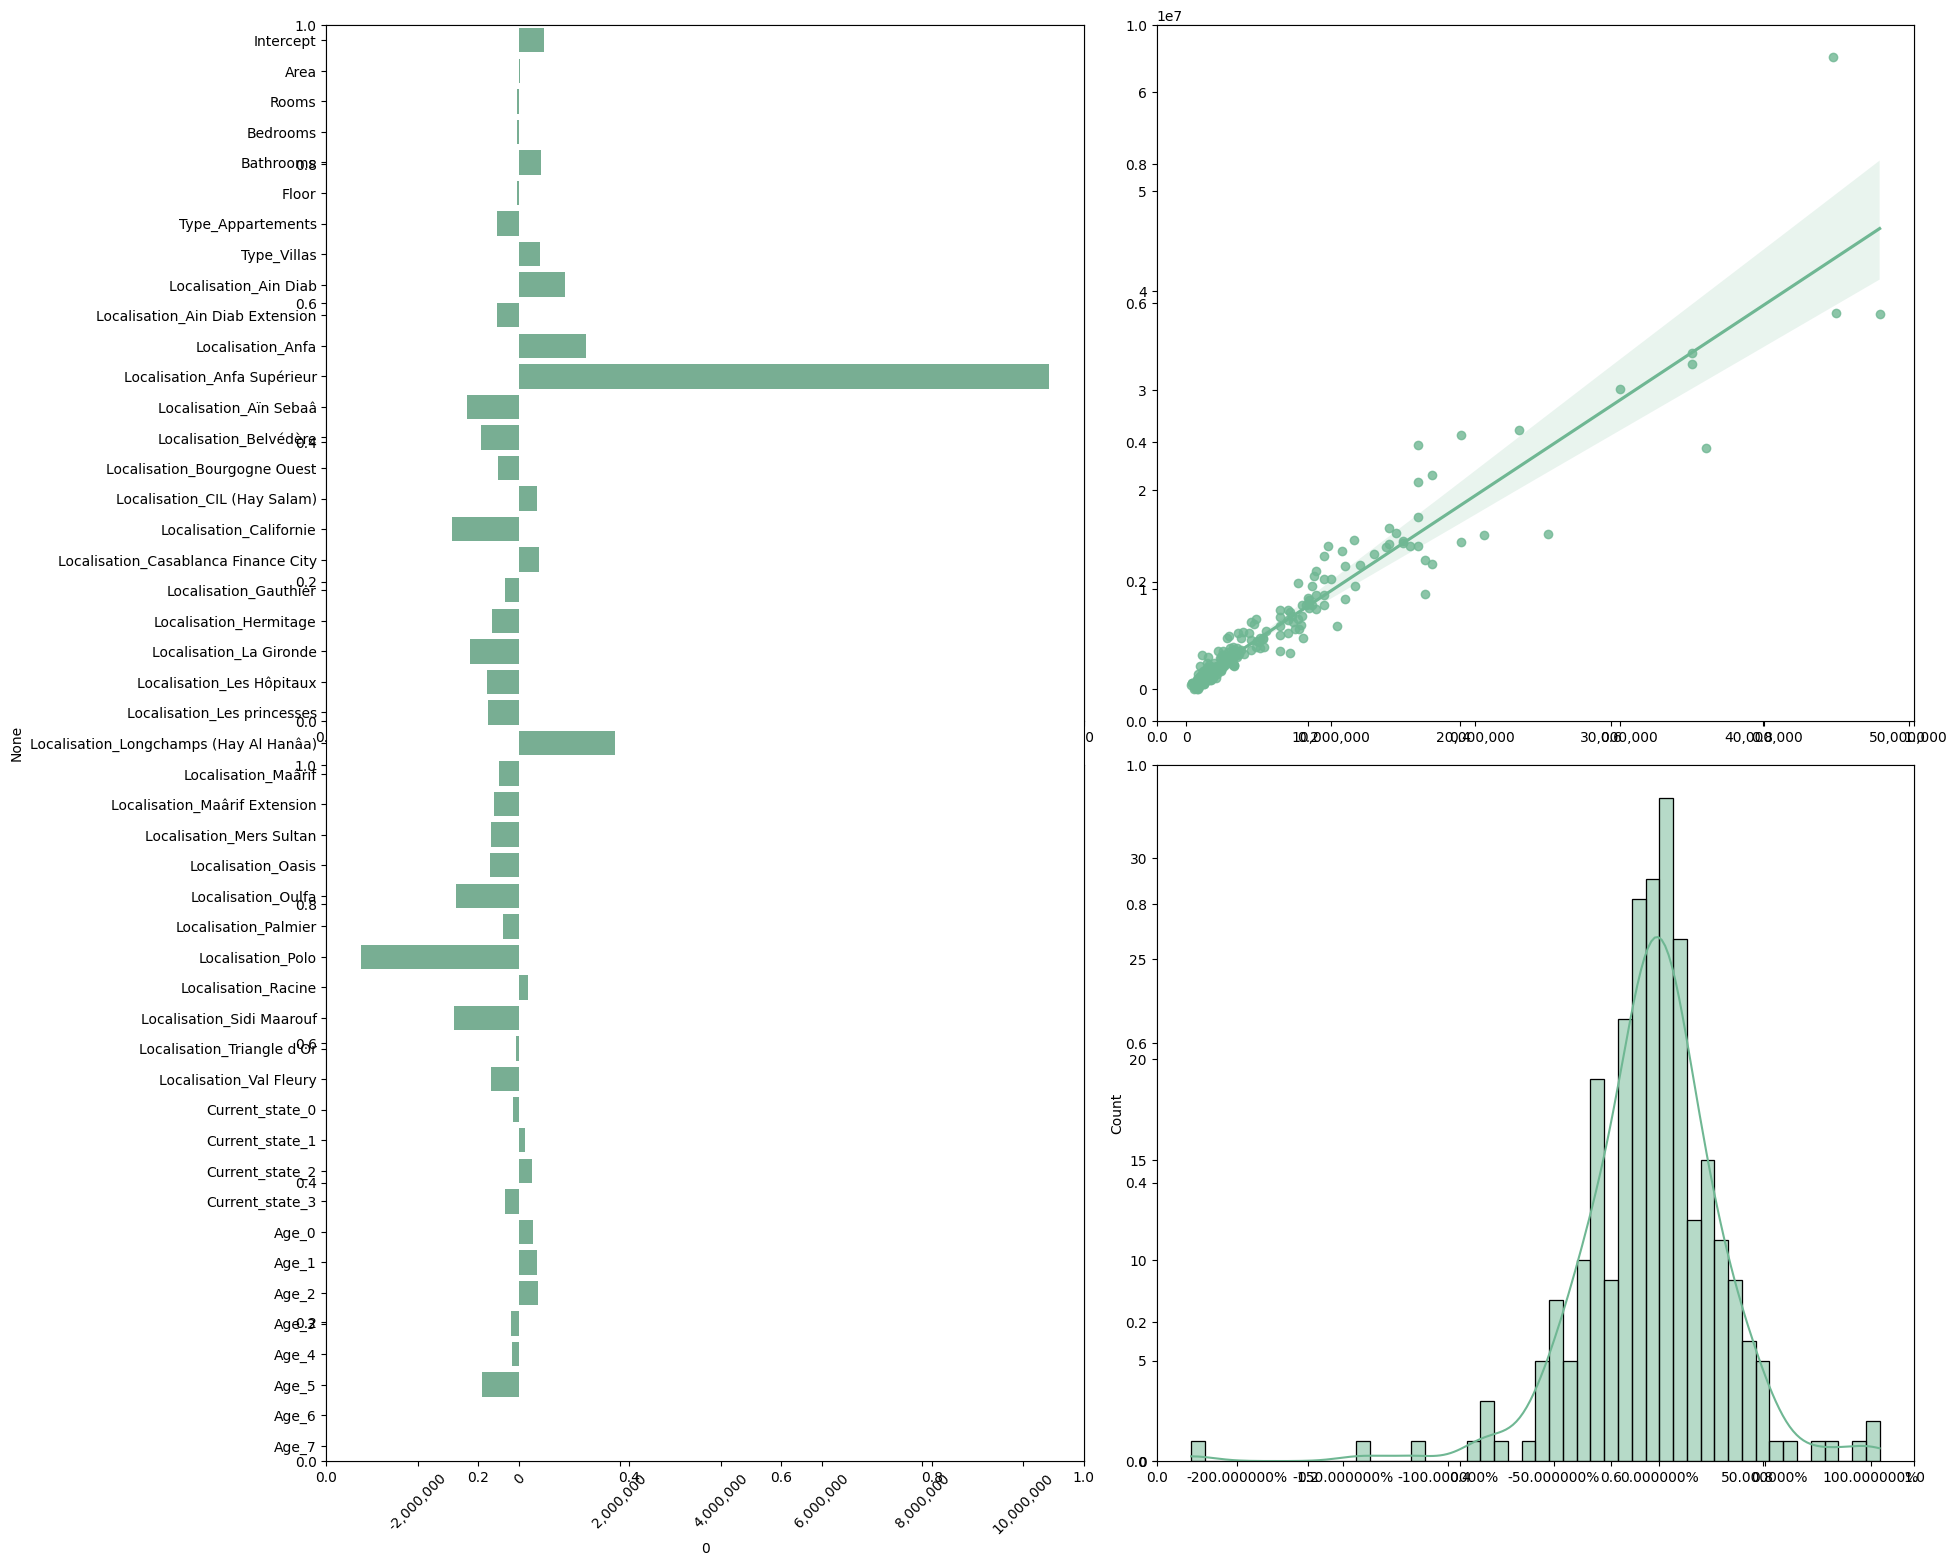

In [15]:
#Use a Ridge regression to introduce regularization
ridge = Ridge()
ridge_hyparams = {'alpha':[0.1,1,3,5]}
ridge_regression = GridSearchCV(ridge,ridge_hyparams,cv = 5)
evaluate_linear_model(X_train,y_train,X_test,y_test,ridge_regression,grid = True)


Best estimator parameters : {'alpha': 0.1}
train RMSE : 1964772.07
test RMSE : 2334096.11
train MAPE : 0.2279
test MAPE : 0.2539
Training set score (R^2): 0.94
Test set score (R^2): 0.90


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Type_Appartements,Type_Villas,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Current_state_2,Current_state_3,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7
0,2.915638e+06,3.985126e+06,-114779.298946,-64756.853762,433770.601014,-143593.548182,-427807.046336,427807.046336,921401.878355,-427430.907874,...,262416.458414,-276936.746492,271965.577737,368421.900636,377604.631082,-161739.934594,-127873.517823,-733619.458441,5240.801402,0.0


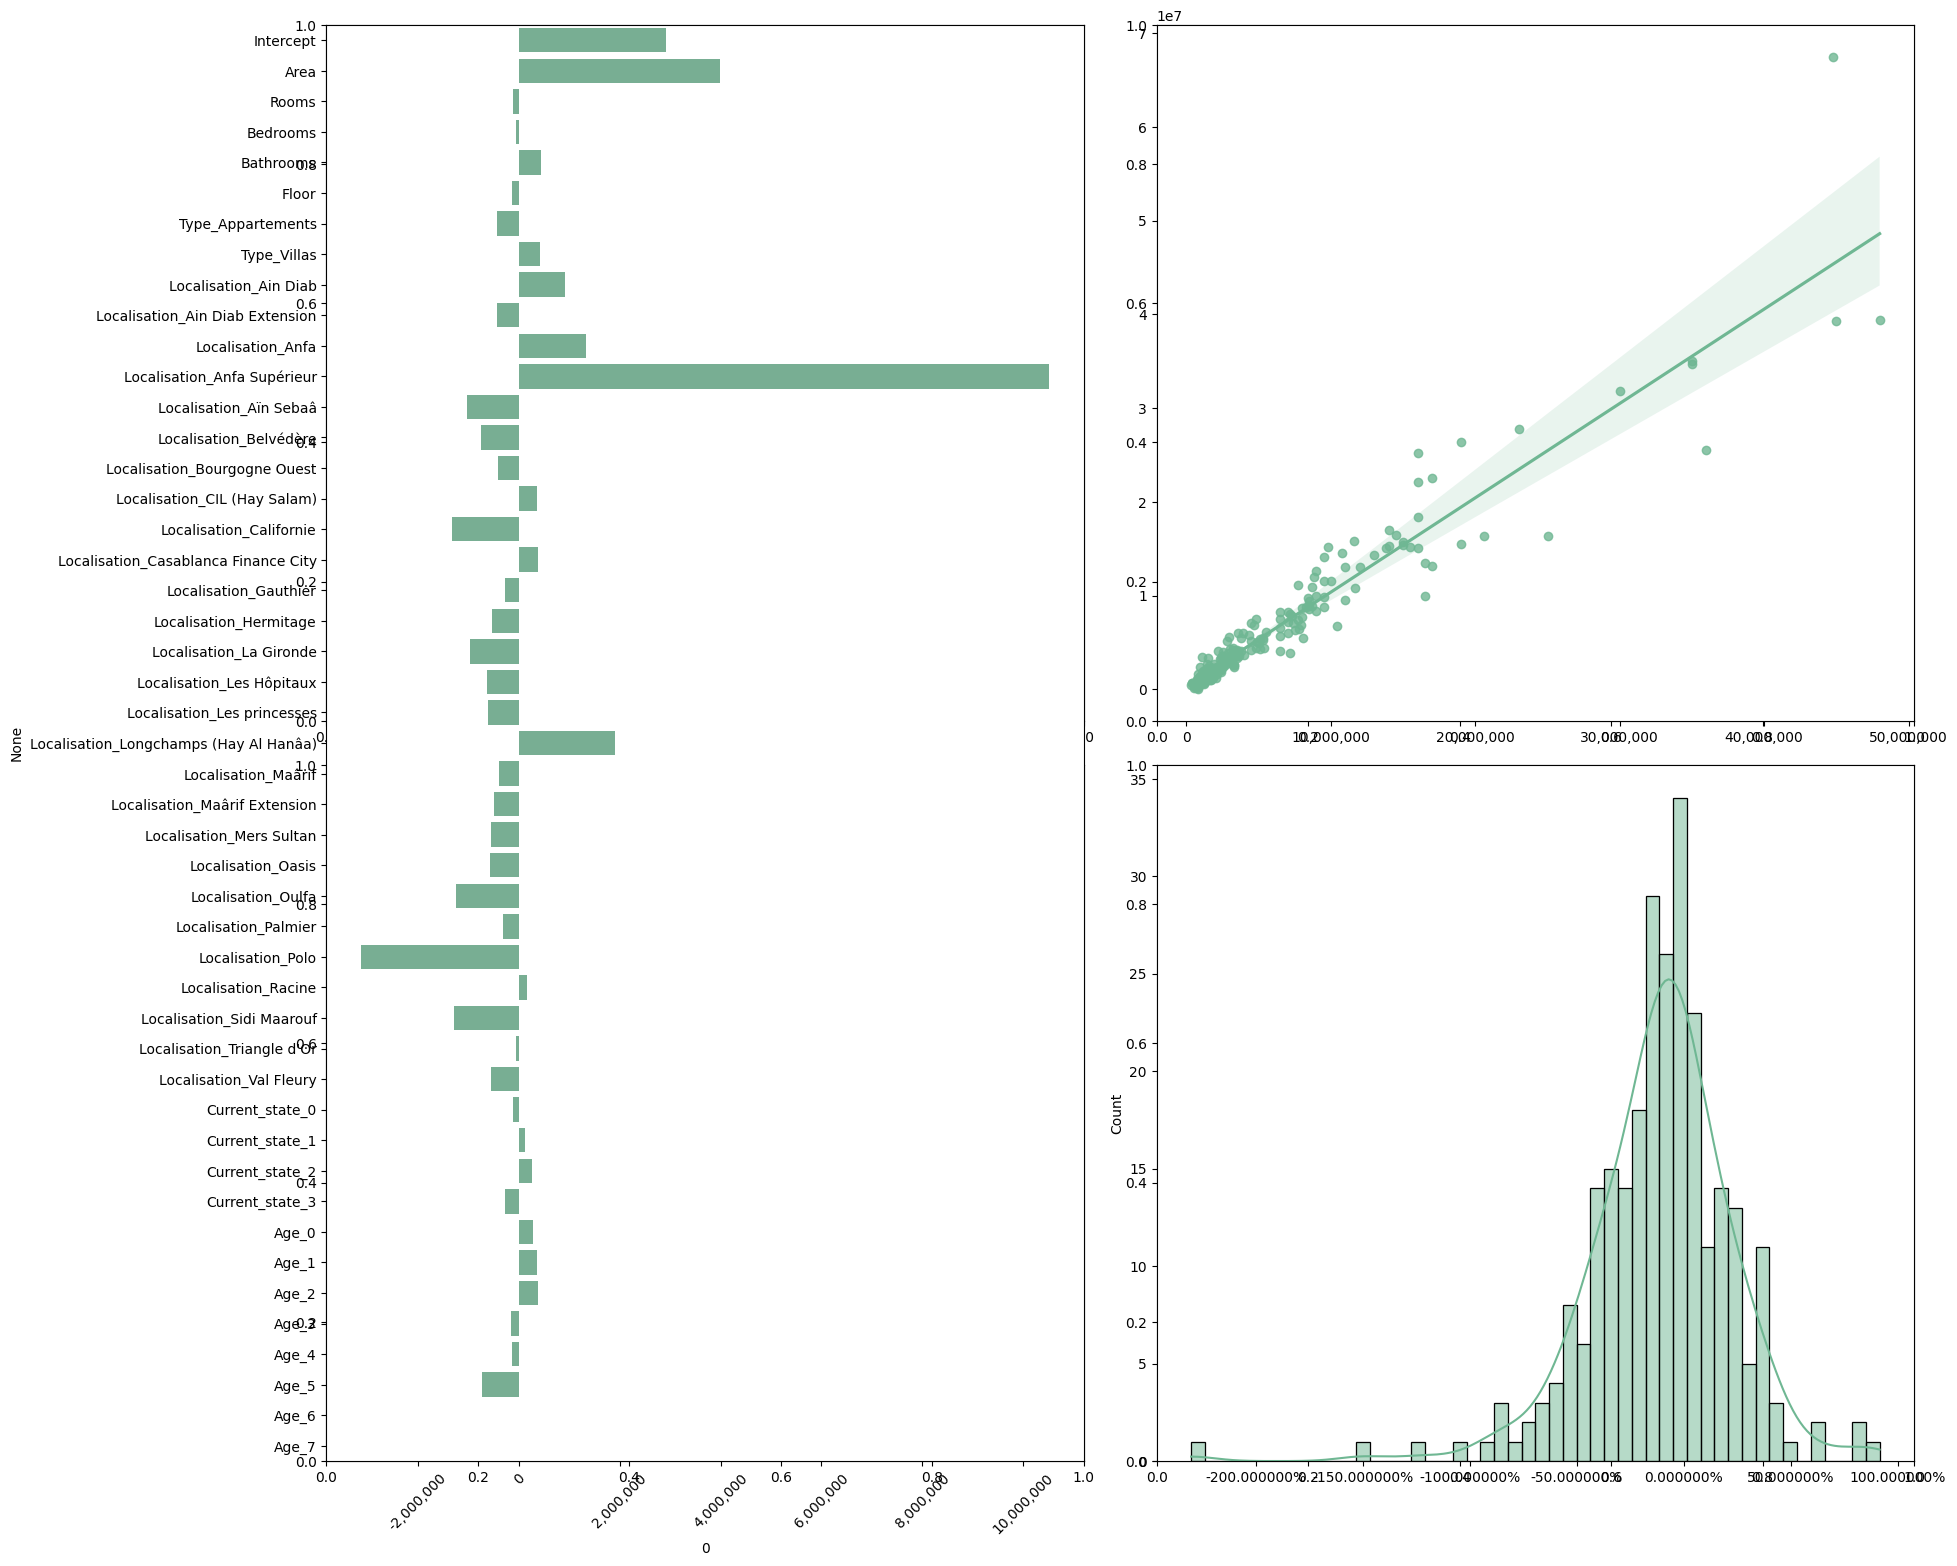

In [16]:


#Use a Ridge regression to introduce regularization with scaled data
evaluate_linear_model(X_train_scaled,y_train,X_test_scaled,y_test,ridge_regression,grid=True)

In [17]:
continuous_vars = ['Area', 'Rooms', 'Bedrooms', 'Bathrooms']

poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X[continuous_vars])

# génère les valeurs
poly_values = poly.transform(X[continuous_vars])

# récupère les noms de colonnes
feature_names = poly.get_feature_names_out(continuous_vars)

# construit le DataFrame
poly_df = pd.DataFrame(poly_values, columns=feature_names)

In [18]:
X_poly = pd.concat([X_dummies,poly_df],axis=1)
X_poly.shape


(892, 60)

In [19]:

#split the data using the same random state for comparable results
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,y,test_size = 0.3,random_state = 123)

In [20]:


scaler = RobustScaler()
X_train_poly_scaled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = X_train_poly.columns)
X_test_poly_scaled = pd.DataFrame(scaler.fit_transform(X_test_poly),columns = X_test_poly.columns)

train RMSE : 1851609.87
test RMSE : 2044400.08
train MAPE : 0.2437
test MAPE : 0.2720
Training set score (R^2): 0.95
Test set score (R^2): 0.92


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Type_Appartements,Type_Villas,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,2.573519e+06,2.656410e+06,273604.048134,305861.490831,-675859.224791,-51303.642297,-183425.82509,183425.82509,1.000394e+06,-715086.574895,...,-97011.269988,186878.717981,-1.511080e+06,570976.38812,207018.066162,211496.883881,-1.492349e+06,-568758.079721,969271.557787,1.285124e+06


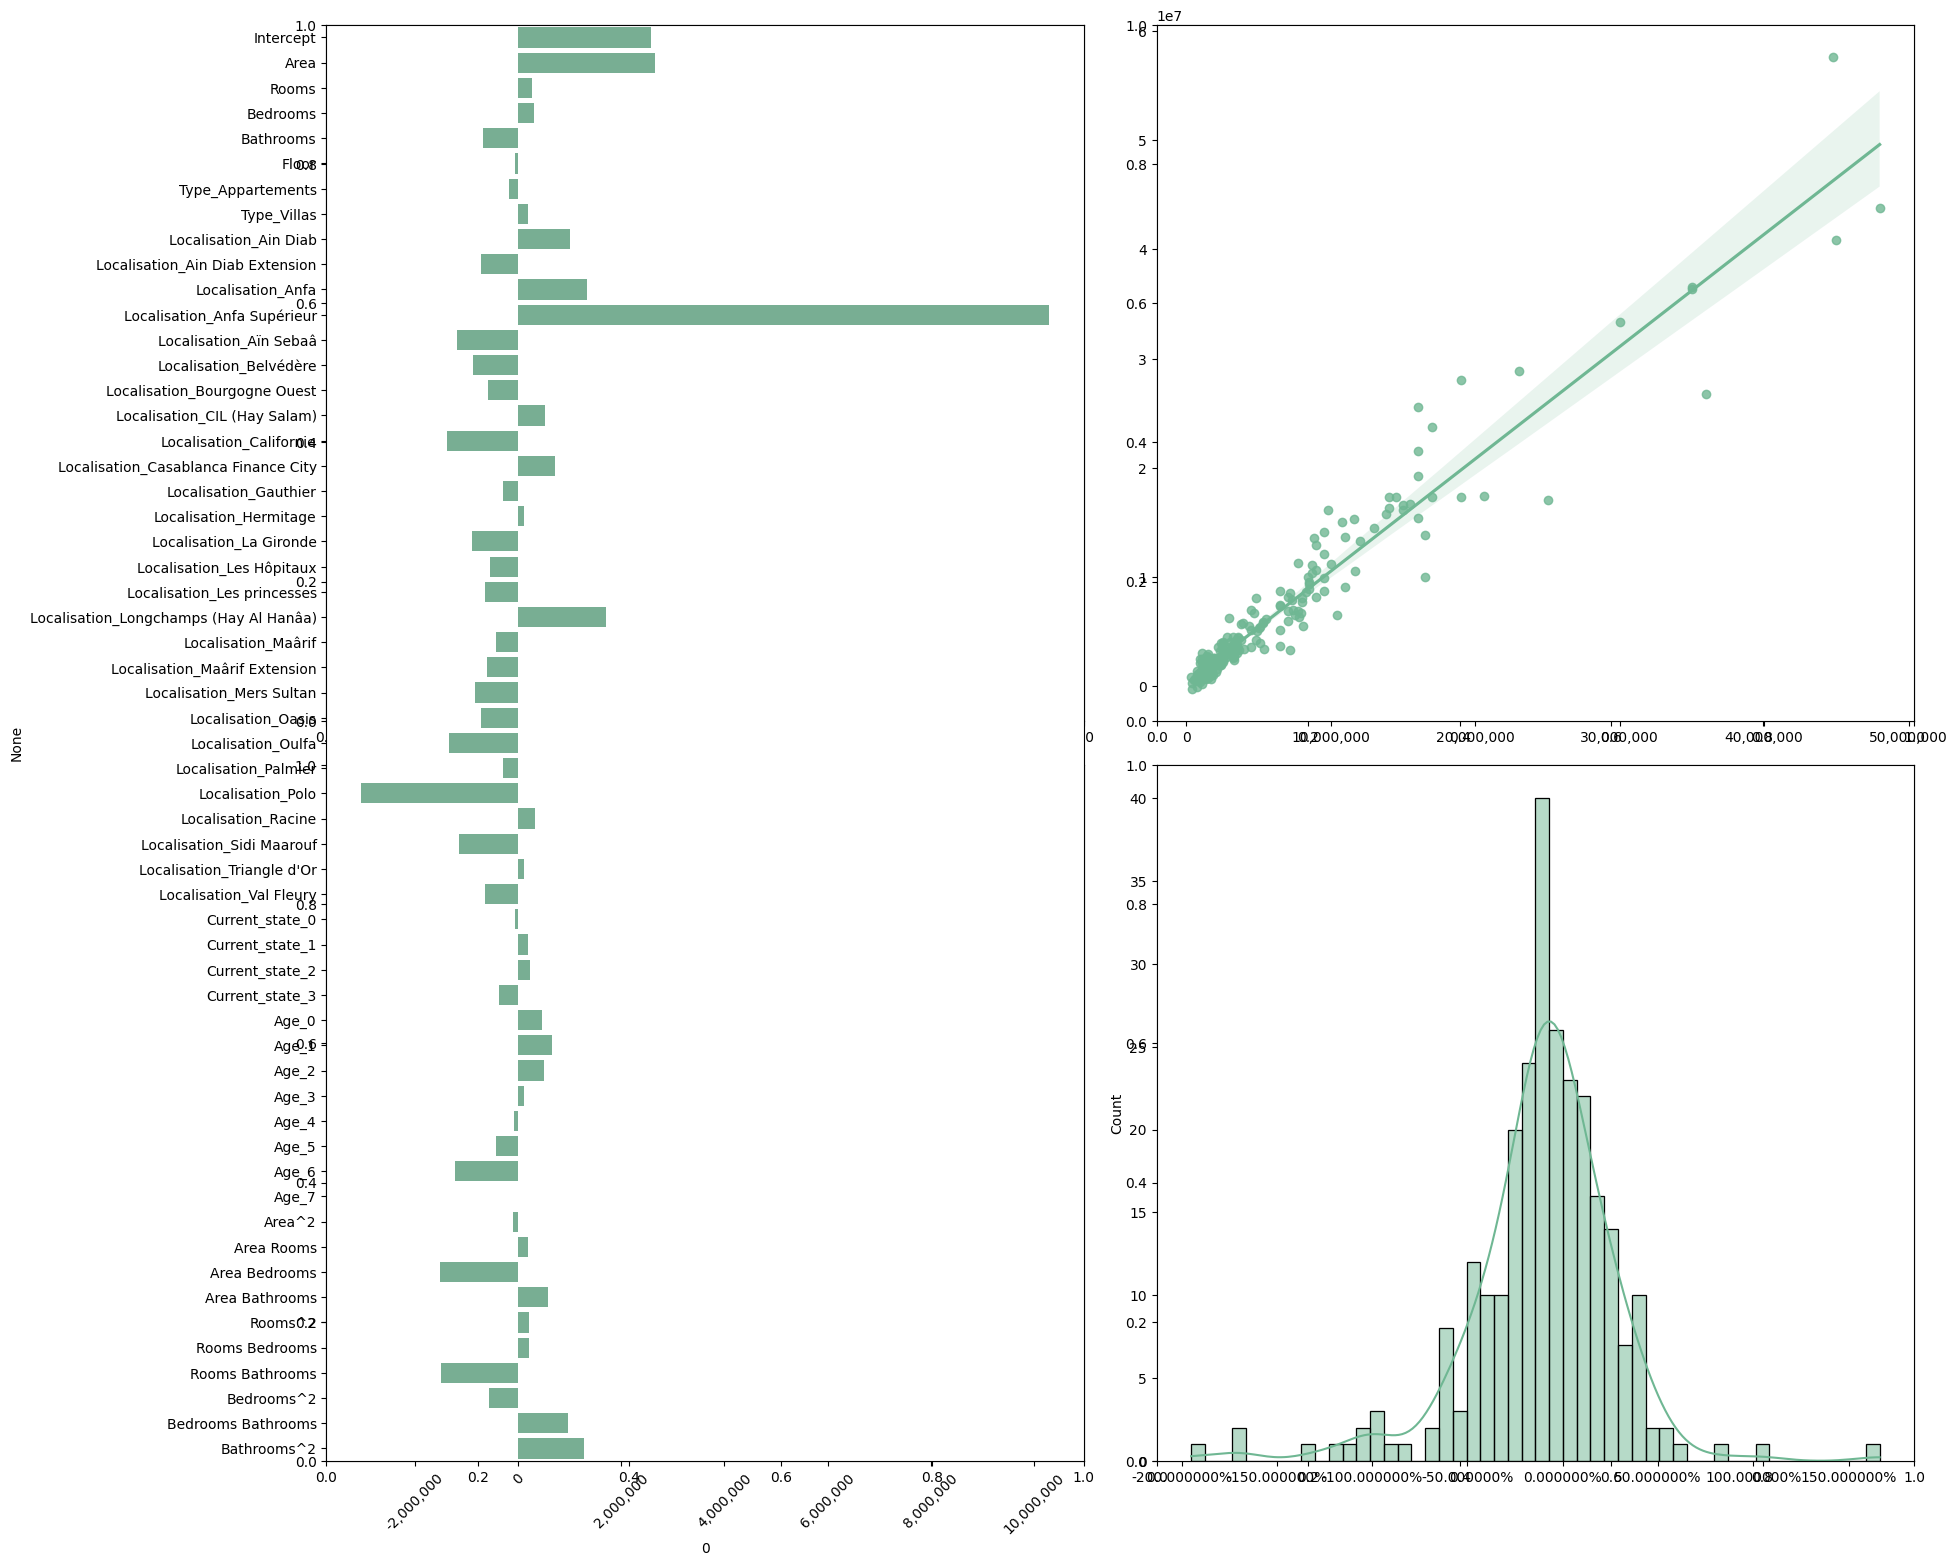

In [21]:
#Evaluate multivariate ols linear regression with polynomial features and feature scaling

poly_linear_regression = LinearRegression()
poly_linear_regression.fit(X_train_poly_scaled,y_train)

evaluate_linear_model(X_train_poly_scaled,y_train_poly,X_test_poly_scaled,y_test_poly,poly_linear_regression)

In [22]:
def evaluate_tree_model(X_train,y_train,X_test,y_test,reg,grid=False):
    
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    RMSE_error_train = np.sqrt(MSE(y_train,reg.predict(X_train)))
    RMSE_error = np.sqrt(MSE(y_test,y_pred))
    MAPE_train = np.median(MAPE(y_train,reg.predict(X_train),multioutput = 'raw_values'))
    MAPE_test = np.median(MAPE(y_test,y_pred, multioutput = 'raw_values'))
    
    if grid:
        print(f'Best estimator parameters : {reg.best_params_}')
        reg = reg.best_estimator_
        
    
    print(f'train RMSE : {RMSE_error_train:.2f}')
    print(f'test RMSE : {RMSE_error:.2f}')
    print(f'train MAPE : {MAPE_train:.4f}')
    print(f'test MAPE : {MAPE_test:.4f}')
    print(f'Training set score: {reg.score(X_train,y_train):.2f}')
    print(f'Test set score: {reg.score(X_test,y_test):.2f}')
    importances_matrix = pd.DataFrame(reg.feature_importances_.reshape(1,-1),columns = X_dummies.columns)
    display(importances_matrix)
    error_matrix = np.array([y_test,(y_test-y_pred)/y_test])
    
    fig,axes = plt.subplots(2,2,figsize = (20,16))
    
    ax1 = plt.subplot2grid((2,2),(0,0),rowspan=2)
    ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1)
    ax3 = plt.subplot2grid((2,2),(1,1),colspan = 1)
    
    g = sns.barplot(y = importances_matrix.columns,x = importances_matrix.iloc[0,:] ,color = cust_pal[5],ax=ax1)
    ax1.tick_params('x',rotation = 45)
    
    g = sns.regplot(x = y_test,y = reg.predict(X_test),color = cust_pal[5],ax=ax2)
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
    
    g = sns.histplot(x = error_matrix[1,:],bins = 50,kde = True, color = cust_pal[5],ax = ax3)
    ax3.xaxis.set_major_formatter(FuncFormatter(lambda x,p: format(x,'%')))
    
    plt.tight_layout()
    plt.show()


Best estimator parameters : {'max_depth': 10, 'max_features': 15, 'n_estimators': 200}
train RMSE : 1078919.22
test RMSE : 1764482.60
train MAPE : 0.1170
test MAPE : 0.1940
Training set score: 0.98
Test set score: 0.94


,Area,Rooms,Bedrooms,Bathrooms,Floor,Type_Appartements,Type_Villas,Localisation_Ain Diab,Localisation_Ain Diab Extension,Localisation_Anfa,...,Current_state_2,Current_state_3,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7
0,0.46243,0.04623,0.04496,0.041861,0.094895,0.09782,0.087394,0.002637,0.00061,0.003212,...,0.008643,0.003379,0.00382,0.002775,0.00223,0.00394,0.005315,0.000609,0.001001,0.0


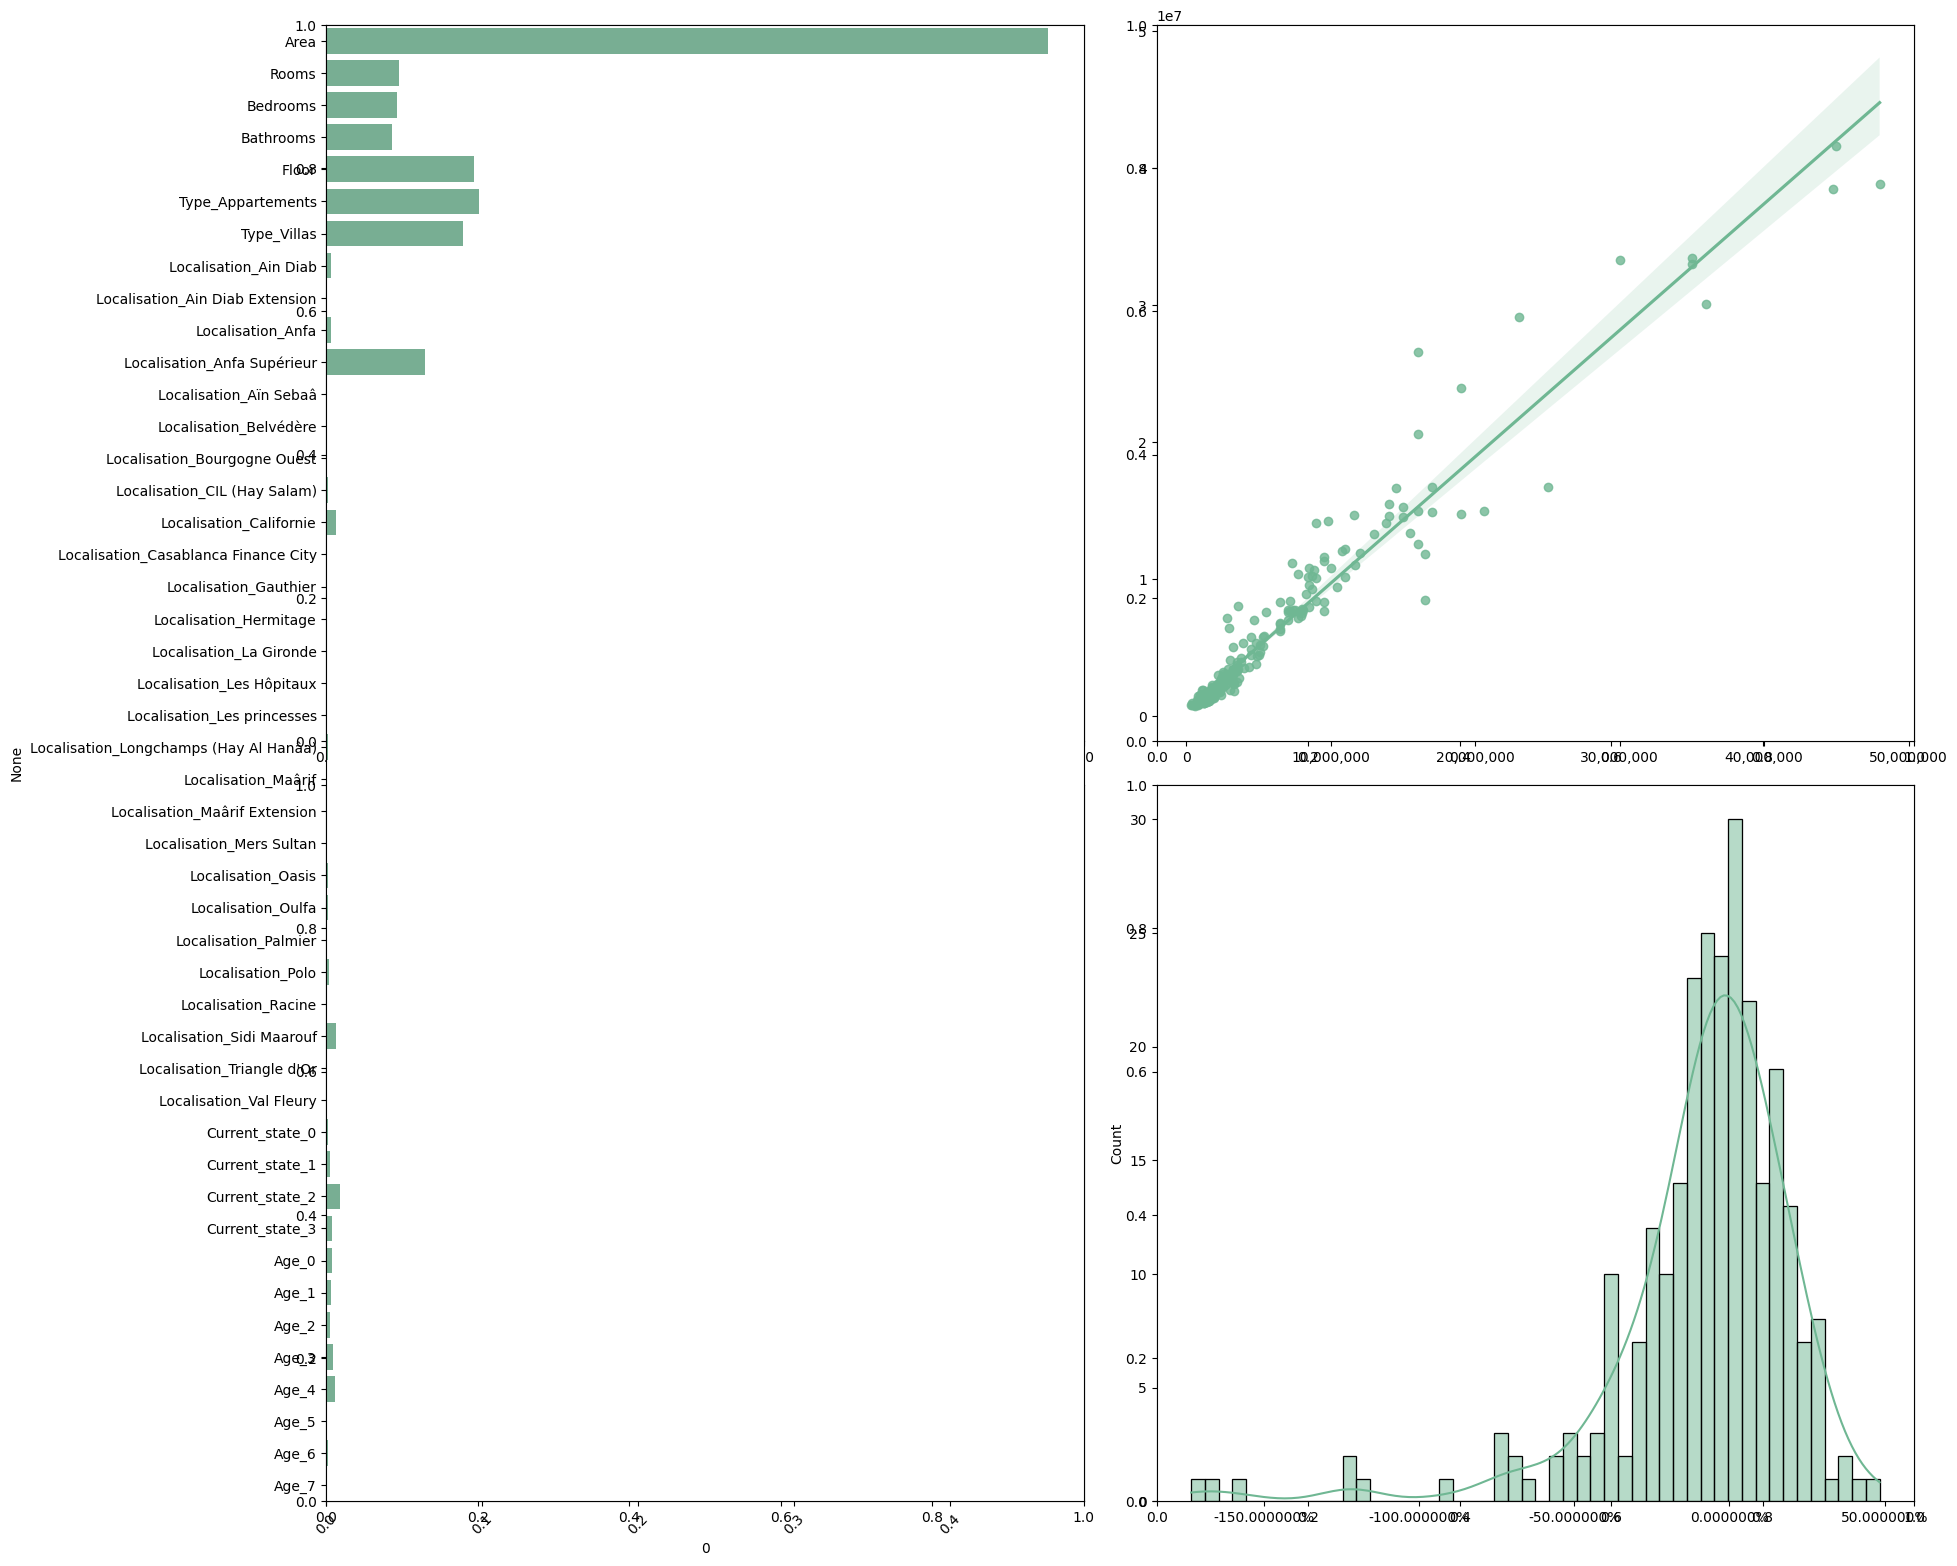

In [23]:
#Use a random forest regressor
rf = RandomForestRegressor(random_state = 123)
rf_hyparams = {'n_estimators' : [100,150,200],'max_depth' : [5,10],'max_features':[15]}
random_forest = GridSearchCV(rf,rf_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,random_forest,grid=True)

Best estimator parameters : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
train RMSE : 861564.72
test RMSE : 1796689.81
train MAPE : 0.1534
test MAPE : 0.1992
Training set score: 0.99
Test set score: 0.94


,Area,Rooms,Bedrooms,Bathrooms,Floor,Type_Appartements,Type_Villas,Localisation_Ain Diab,Localisation_Ain Diab Extension,Localisation_Anfa,...,Current_state_2,Current_state_3,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7
0,0.916296,0.003167,0.004112,0.0097,0.005013,0.002585,0.001609,0.000446,0.000098,0.00206,...,0.013034,0.000727,0.000581,0.000113,0.001201,0.004179,0.000758,0.000104,0.000026,0.0


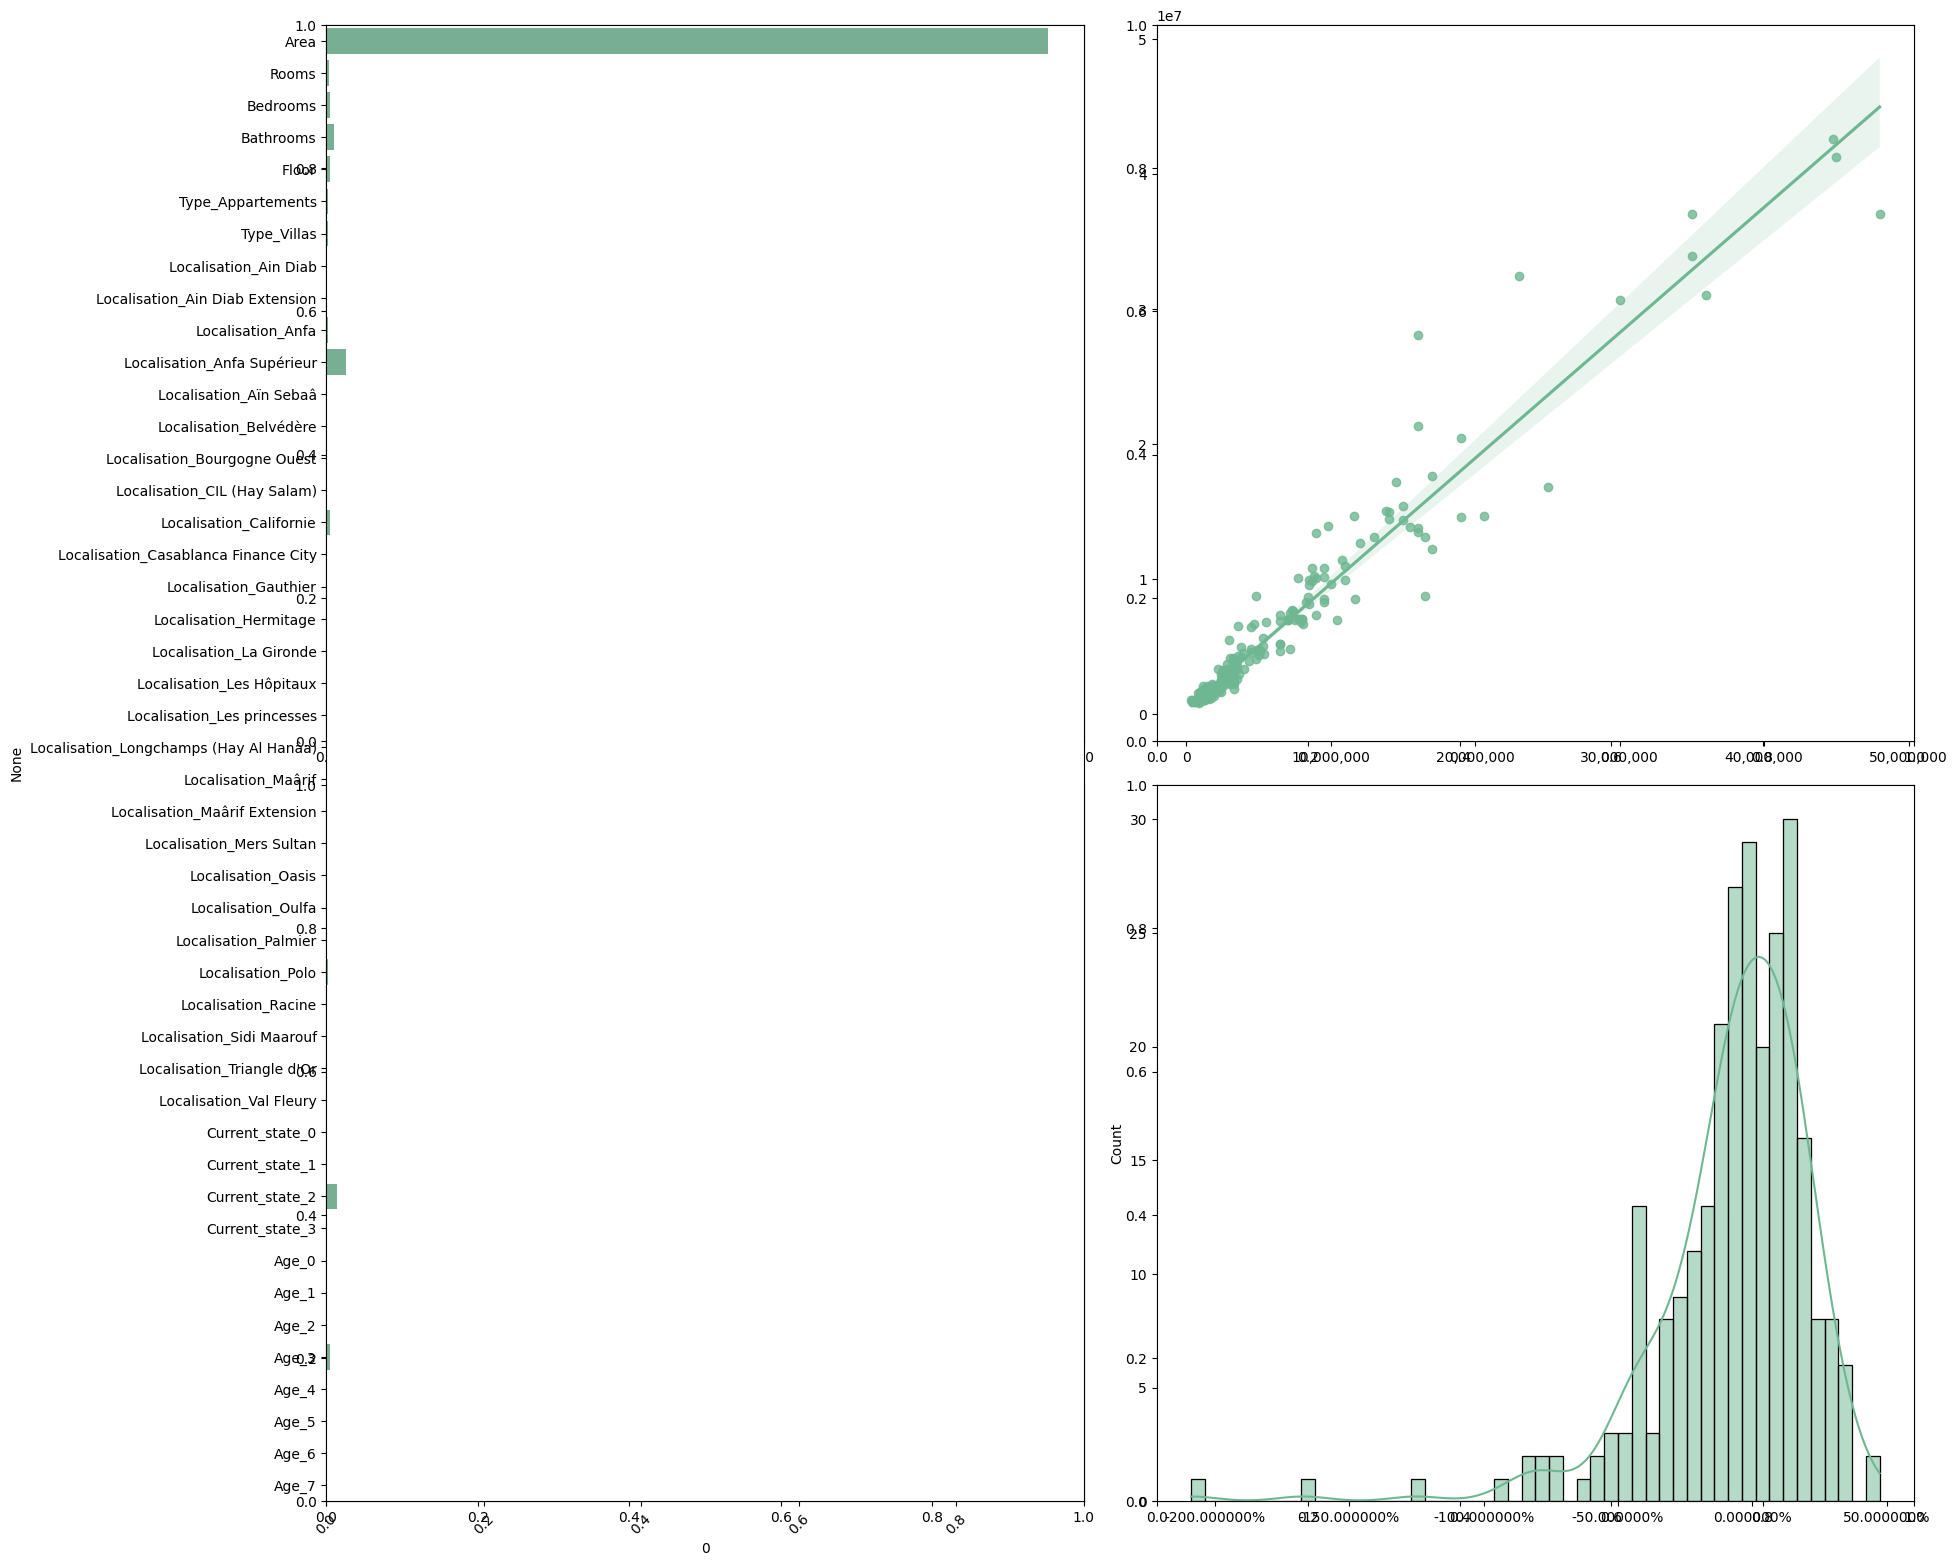

In [24]:
#Use a gradient boosting regressor
gb = GradientBoostingRegressor(random_state = 123)
gb_hyparams = {'n_estimators' : [10,50,100,200],'max_depth' : [3,5,10,15],'learning_rate':[0.05,0.1,0.5]}
gradient_boosted_regressor = GridSearchCV(gb,gb_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,gradient_boosted_regressor,grid=True)

In [25]:
#Select columns to keep for modeling
cols_to_keep = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age','Price_m2']
df_model = df[cols_to_keep]


In [26]:
#Data preprocessing : Missing values
display(df_model.isna().sum())

Type               0
Localisation       0
Area               0
Rooms              0
Bedrooms           0
Bathrooms          0
Floor              0
Current_state     37
Age              239
Price_m2           0
dtype: int64

In [27]:
#drop listings where all four continuous variables are missing
df_model = df_model.dropna(subset = ['Rooms','Bedrooms','Bathrooms','Floor']).reset_index(drop = True)

In [28]:
#Split dataframe into Features and Target Variable

features = ['Type','Localisation','Area','Rooms','Bedrooms','Bathrooms','Floor','Current_state','Age']
X = df_model[features]
y = df_model['Price_m2'].values 

In [29]:
#Encode ordinal variables

X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-50 ans",6).replace("50-70 ans",7)


C:\Users\R.BENZARIA\AppData\Local\Temp\ipykernel_9988\2630630292.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:,'Current_state'] = X['Current_state'].replace(np.nan,0).replace('Nouveau',1).replace('Bon état',2).replace('À rénover',3)
C:\Users\R.BENZARIA\AppData\Local\Temp\ipykernel_9988\2630630292.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:,'Age'] = X['Age'].replace(np.nan,0).replace("Moins d'un an",1).replace("1-5 ans",2).replace("5-10 ans",3).replace("10-20 ans",4).replace("20-30 ans",5).replace("30-

In [30]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)


In [31]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,test_size = 0.3,random_state = 123)


In [32]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

train RMSE : 2979.68
test RMSE : 3240.84
train MAPE : 0.1525
test MAPE : 0.1624
Training set score (R^2): 0.54
Test set score (R^2): 0.47


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Type_Appartements,Type_Villas,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Current_state_2,Current_state_3,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7
0,18165.022093,-2.422705,-196.6357,-278.61394,314.311074,100.280984,-1827.362394,1827.362394,1250.848434,521.591583,...,-82.043996,-487.965128,939.348409,1744.779813,472.717612,-516.467179,-742.288658,-2332.847695,434.757697,0.0


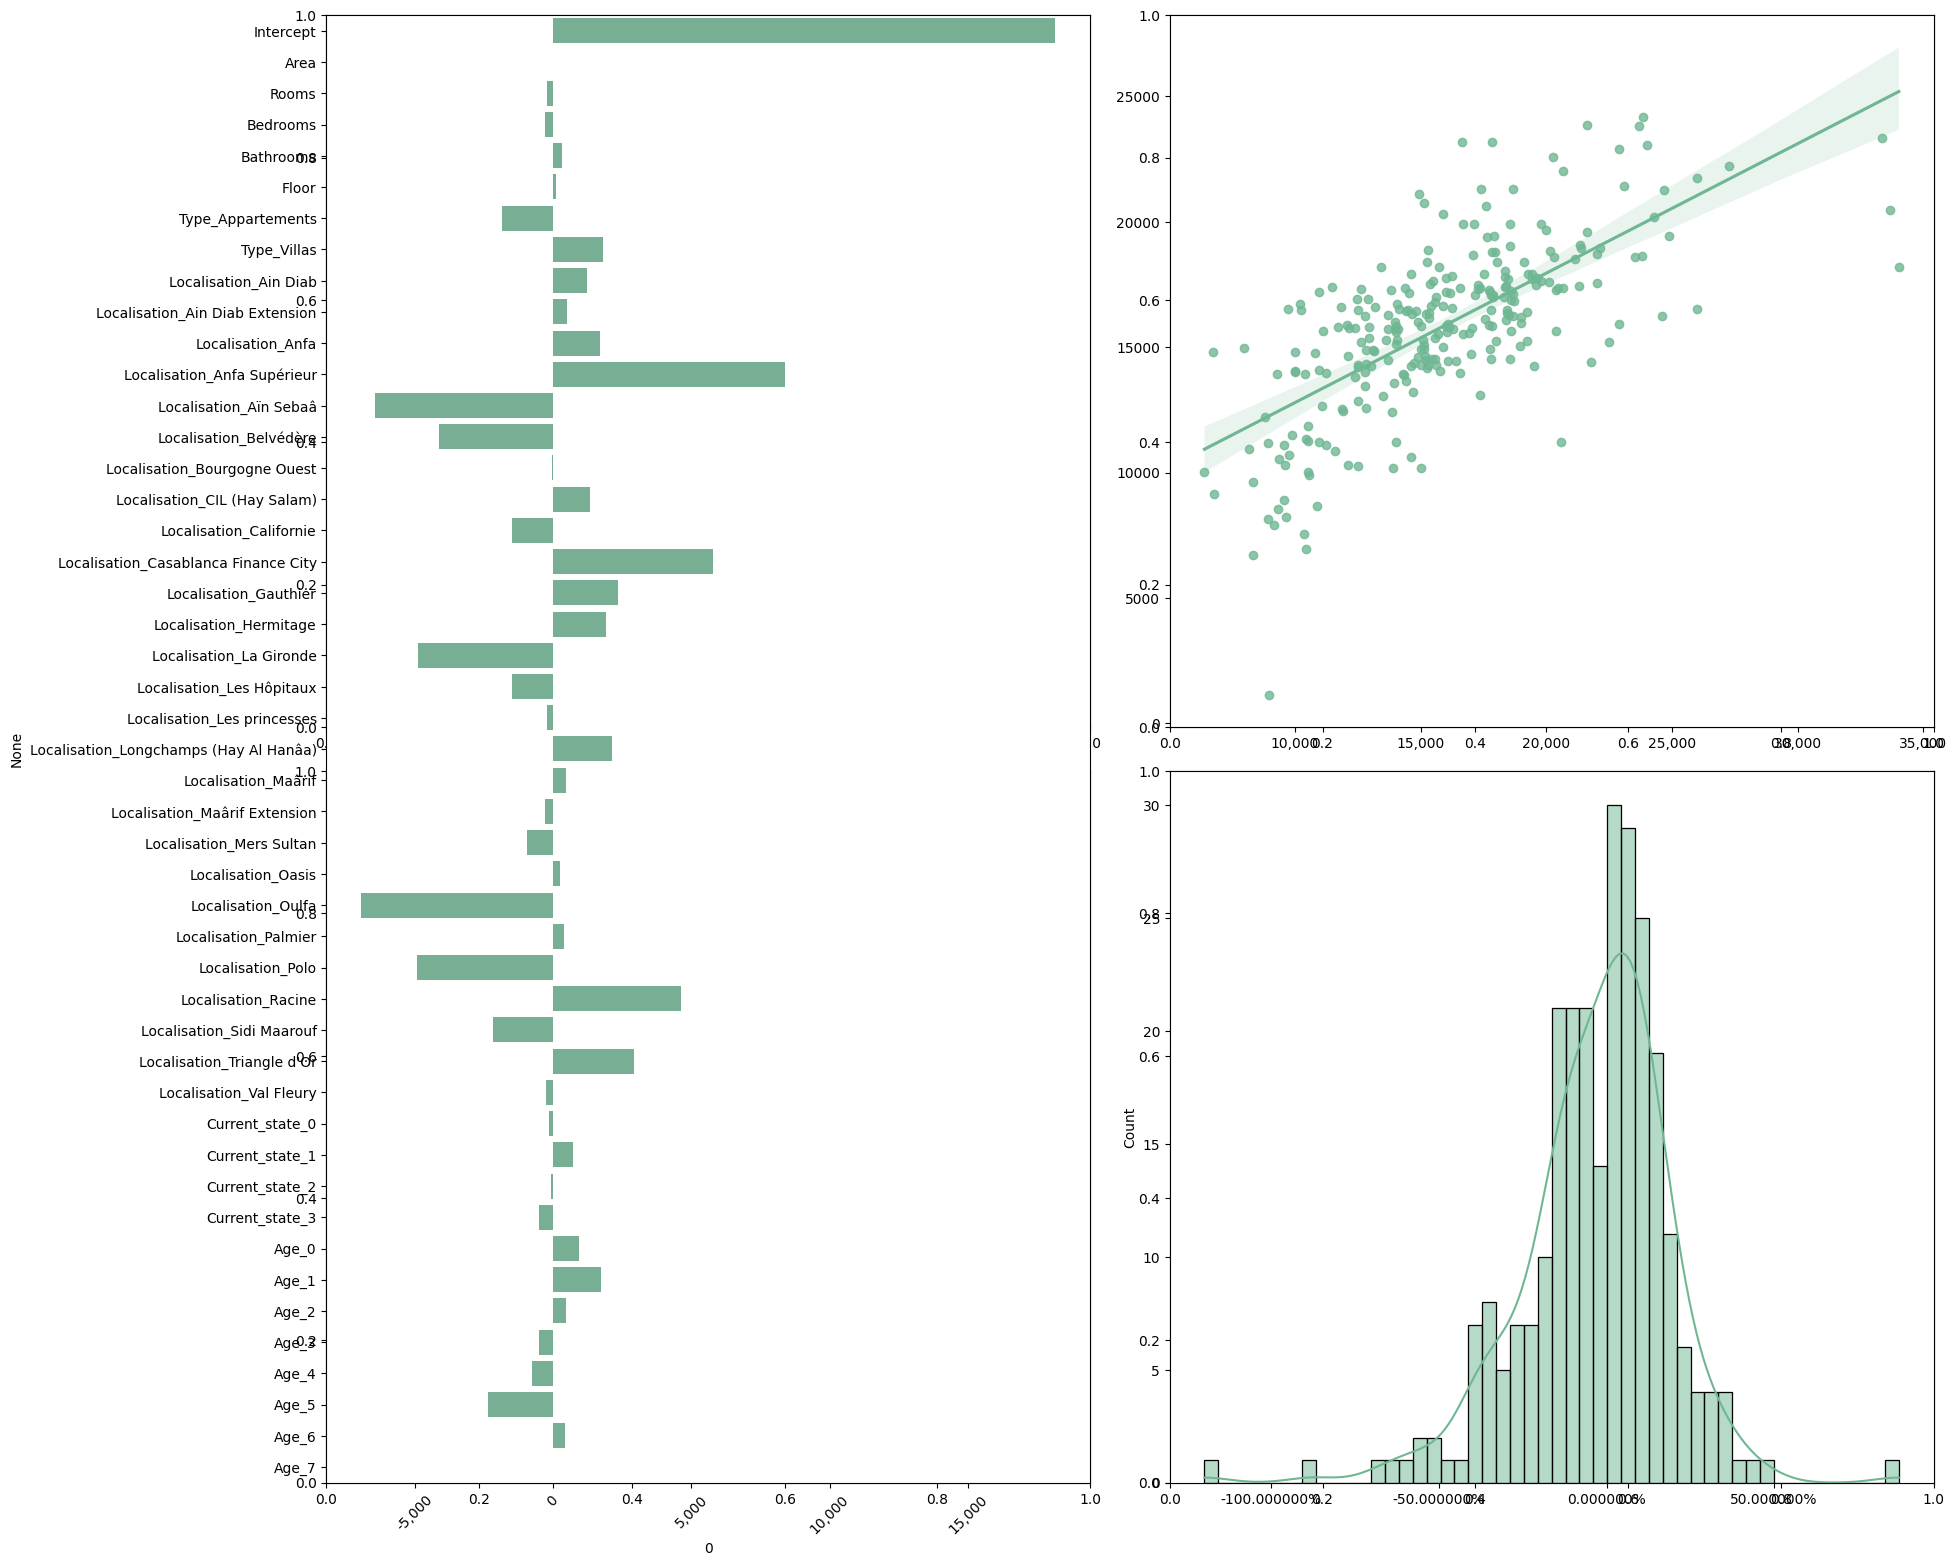

In [33]:
#Evaluate multivariate ols linear regression


reg = LinearRegression()
evaluate_linear_model(X_train,y_train,X_test,y_test,reg)



In [34]:
#Encode categorical variables remaining
X_dummies = pd.get_dummies(X)


In [35]:
X_poly = pd.concat([X_dummies,poly_df],axis=1)
X_poly.shape


(892, 60)

In [36]:
#split the data using the same random state for comparable results
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly,y,test_size = 0.3,random_state = 123)

In [37]:
scaler = RobustScaler()
X_train_poly_scaled = pd.DataFrame(scaler.fit_transform(X_train_poly),columns = X_train_poly.columns)
X_test_poly_scaled = pd.DataFrame(scaler.fit_transform(X_test_poly),columns = X_test_poly.columns)

X_train_poly_scaled

,Area,Rooms,Bedrooms,Bathrooms,Floor,Type_Appartements,Type_Villas,Localisation_Ain Diab,Localisation_Ain Diab Extension,Localisation_Anfa,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,0.666140,1.25,0.5,1.0,-0.50,-1.0,1.0,1.0,0.0,0.0,...,0.681837,0.975669,0.657022,0.653474,1.625,1.315068,1.416667,0.583333,0.750,1.0
1,-0.249408,0.75,1.0,0.0,-0.50,-1.0,1.0,0.0,0.0,0.0,...,-0.115337,-0.065195,-0.045189,-0.182058,0.825,1.260274,0.333333,1.333333,0.500,0.0
2,0.950276,0.50,0.5,0.0,-0.50,-1.0,1.0,0.0,0.0,0.0,...,1.138151,0.761484,0.891092,0.486368,0.500,0.657534,0.166667,0.583333,0.250,0.0
3,2.822415,0.50,1.0,3.0,-0.50,-1.0,1.0,0.0,0.0,0.0,...,6.618855,2.098450,3.118010,4.307828,0.500,0.986301,1.666667,1.333333,2.375,4.2
4,0.148382,1.50,0.0,1.0,1.50,0.0,0.0,0.0,0.0,0.0,...,0.104793,0.498450,0.096554,0.220756,2.100,0.986301,1.666667,0.000000,0.375,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0.337806,0.75,0.5,2.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.277789,0.424049,0.386541,0.613017,0.825,0.876712,1.500000,0.583333,1.250,2.4
620,0.123125,0.00,0.0,1.0,1.00,0.0,0.0,0.0,0.0,0.0,...,0.085050,0.021982,0.080949,0.199648,0.000,0.000000,0.166667,0.000000,0.375,1.0
621,-0.148382,-0.25,-0.5,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,-0.077805,-0.149366,-0.159623,-0.125770,-0.175,-0.328767,-0.333333,-0.416667,-0.250,0.0
622,-0.214680,-0.25,0.0,-1.0,0.25,0.0,0.0,0.0,0.0,0.0,...,-0.103846,-0.173039,-0.127763,-0.242744,-0.175,-0.164384,-0.583333,0.000000,-0.375,-0.6


train RMSE : 2823.33
test RMSE : 3385.51
train MAPE : 0.1456
test MAPE : 0.1654
Training set score (R^2): 0.59
Test set score (R^2): 0.42


,Intercept,Area,Rooms,Bedrooms,Bathrooms,Floor,Type_Appartements,Type_Villas,Localisation_Ain Diab,Localisation_Ain Diab Extension,...,Area^2,Area Rooms,Area Bedrooms,Area Bathrooms,Rooms^2,Rooms Bedrooms,Rooms Bathrooms,Bedrooms^2,Bedrooms Bathrooms,Bathrooms^2
0,14205.088235,-1719.666681,427.782939,-915.908565,-8.825868,513.376279,-2771.261373,2771.261373,1166.970682,551.603488,...,173.483438,936.956329,634.724427,-60.762097,-20.073758,588.81783,-2512.901205,1943.67348,-2446.44908,2135.988776


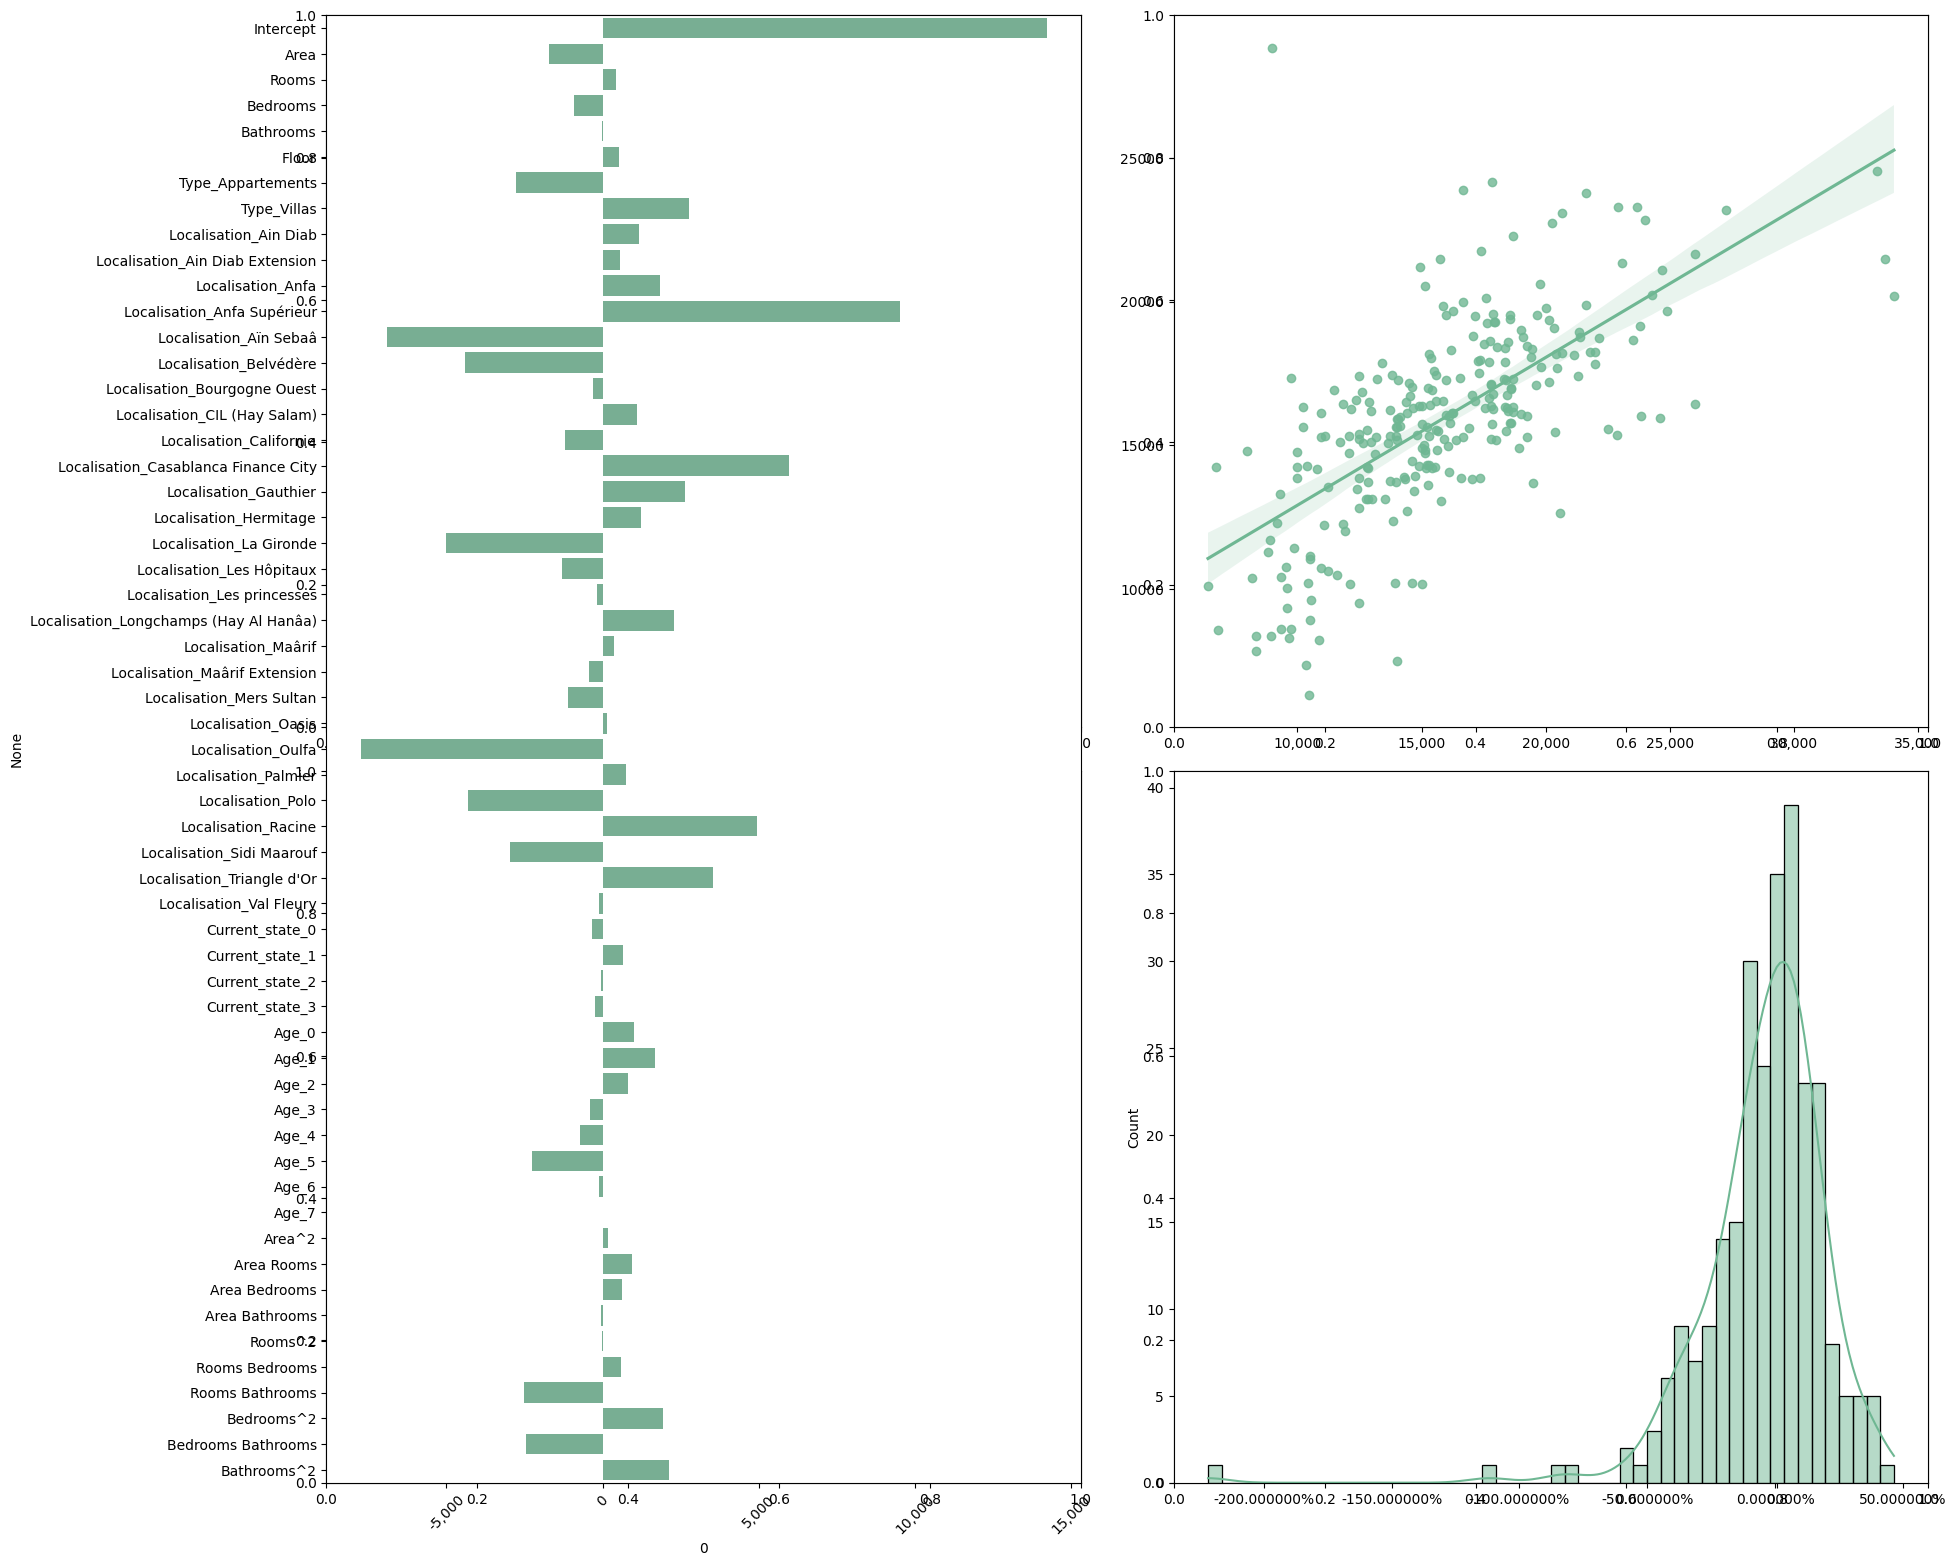

In [38]:
#Evaluate multivariate ols linear regression with polynomial features and feature scaling

reg = LinearRegression()
reg.fit(X_train_poly_scaled,y_train)

evaluate_linear_model(X_train_poly_scaled,y_train_poly,X_test_poly_scaled,y_test_poly,reg)

Best estimator parameters : {'max_depth': 10, 'max_features': 10, 'n_estimators': 50}
train RMSE : 2499.37
test RMSE : 3363.25
train MAPE : 0.1336
test MAPE : 0.1764
Training set score: 0.68
Test set score: 0.43


c:\Users\R.BENZARIA\Desktop\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,Area,Rooms,Bedrooms,Bathrooms,Floor,Type_Appartements,Type_Villas,Localisation_Ain Diab,Localisation_Ain Diab Extension,Localisation_Anfa,...,Current_state_2,Current_state_3,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7
0,0.149087,0.054857,0.042781,0.047293,0.039138,0.012909,0.012254,0.009426,0.00192,0.006695,...,0.023634,0.004929,0.018094,0.01293,0.010448,0.011245,0.010858,0.016468,0.006557,0.0


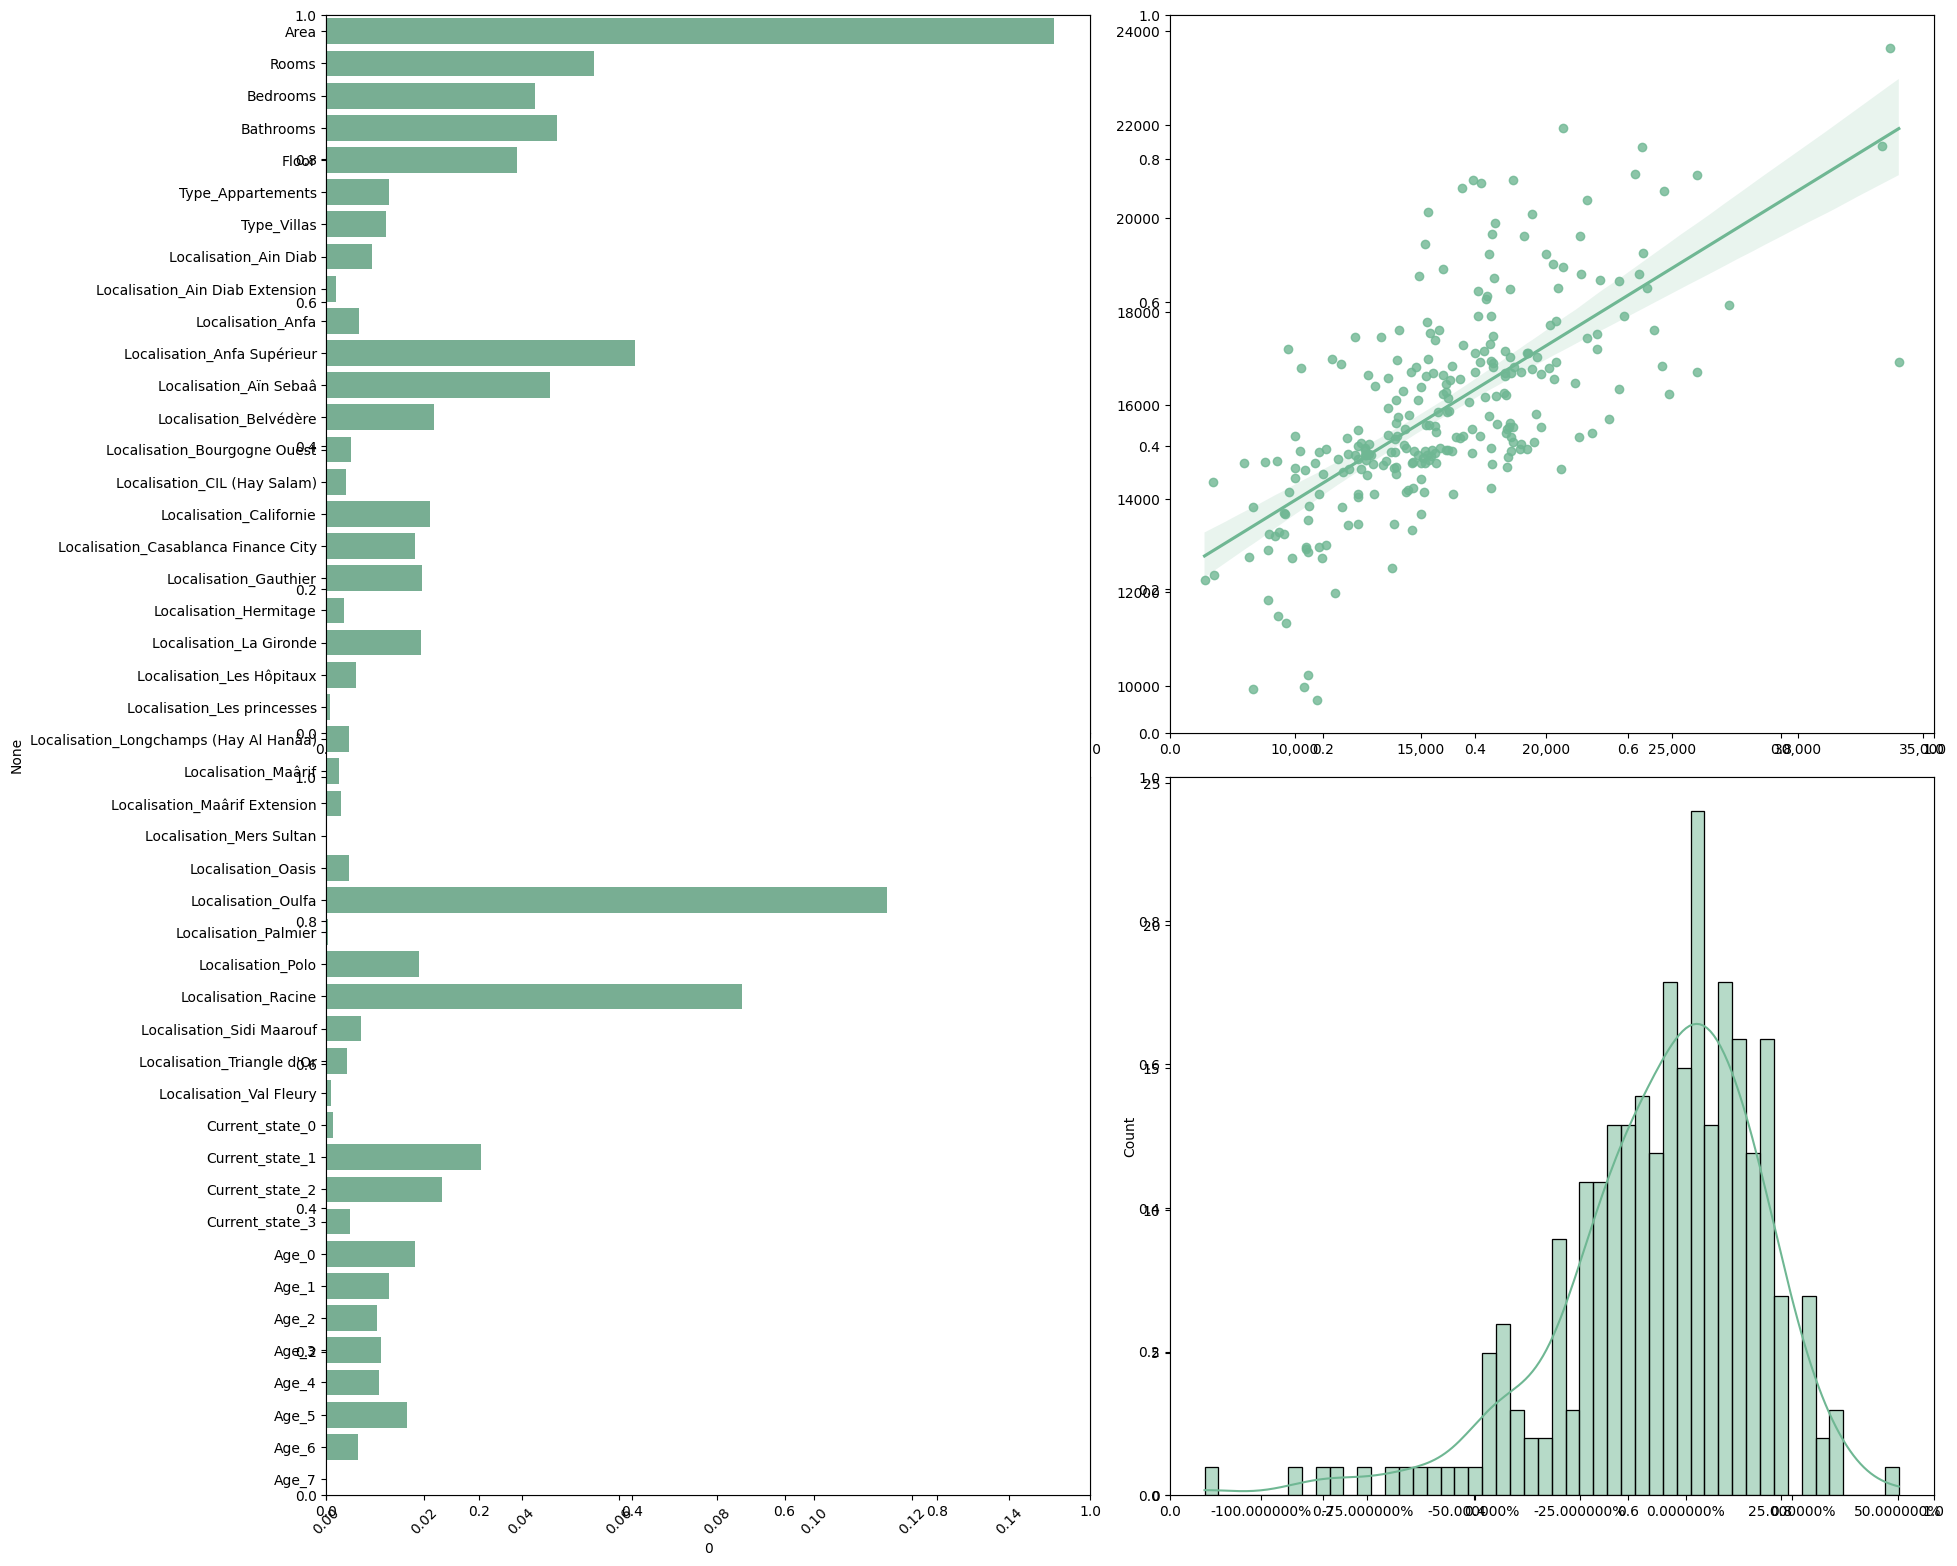

In [39]:
#Use a random forest regressor
rf = RandomForestRegressor()
rf_hyparams = {'n_estimators' : [10,50,100,200],'max_depth' : [5,10],'max_features':[10]}
reg = GridSearchCV(rf,rf_hyparams,cv = 5)
evaluate_tree_model(X_train,y_train,X_test,y_test,reg,grid=True)
